# Tabularize time series

In this assignment, your task is to convert **time series data** into a **tabular data set**.

You need to create suitable input features from a time series containing weekly sales to be able to forecast sales for the next week.

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from feature_engine.creation import CyclicalFeatures

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error as mse

In [2]:
# load weekly sales dataset

filename = "../../Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


# Data analysis

First, explore the time series.

## Plot time series

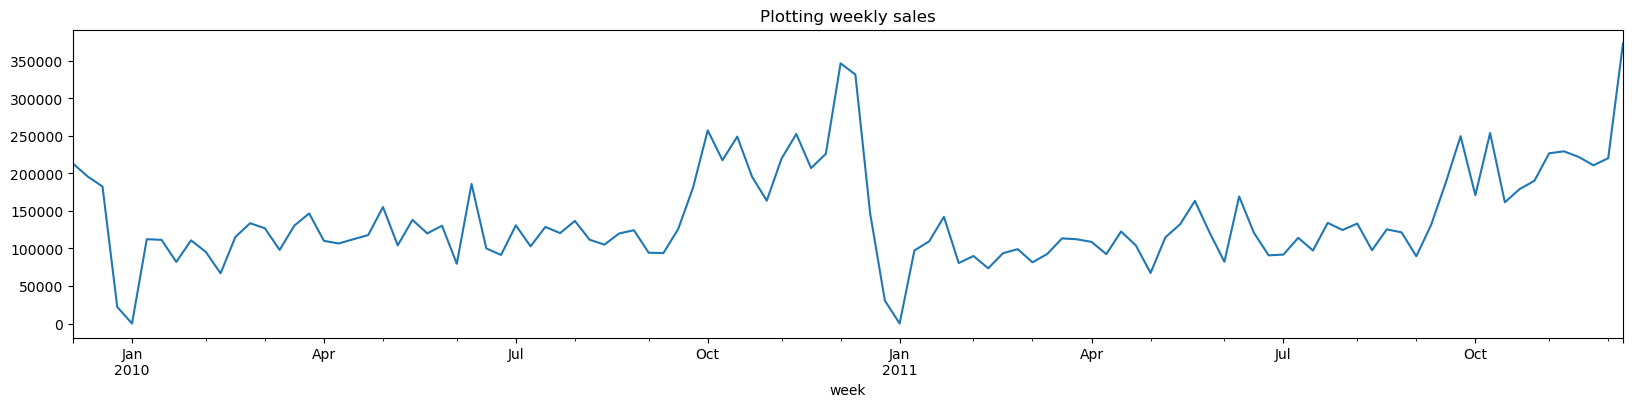

In [3]:
df['sales'].plot(figsize = (20, 4))
plt.title("Plotting weekly sales")
plt.show()

## Missing data

Check if there are missing values in the time series.

In [4]:
# No missing data
df.isnull().sum()

sales    0
dtype: int64

## Missing timestamps

Check if there are missing timestamps in the index.

sales    0
dtype: int64


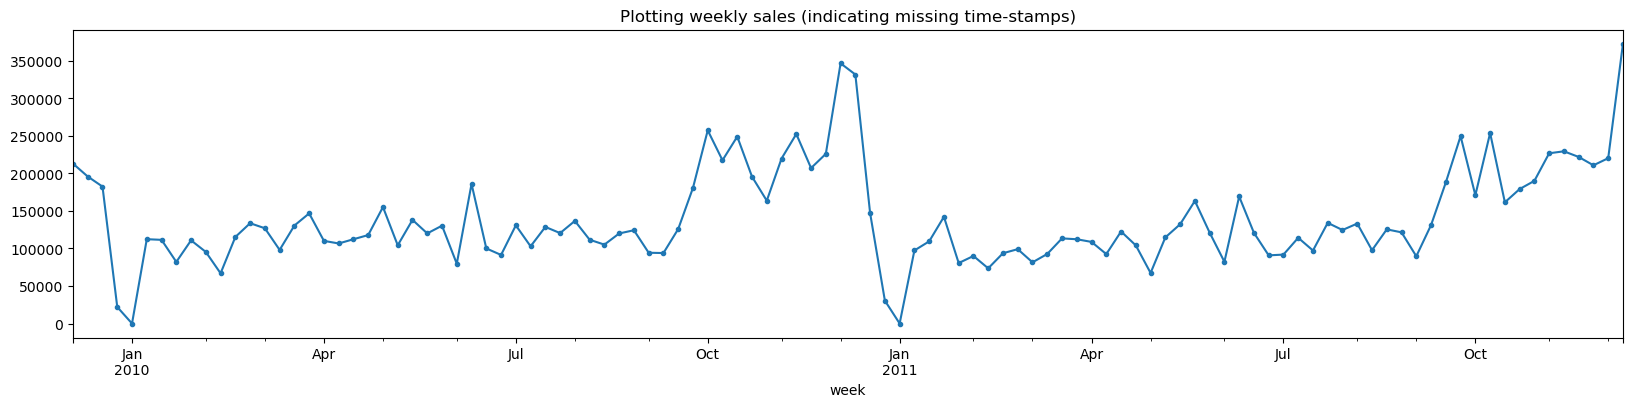

In [5]:
# No missing time-stamps as well
df_ = df.asfreq("1W")
print(df_.isnull().sum())
df_imputed = df_.fillna(method = 'ffill')

# Plot the time-series
ax = df_['sales'].plot(linestyle = '-', marker = '.', figsize = [20, 4])
df_imputed[df_.isnull()]['sales'].plot(ax = ax, legend = None, marker = '.', color = 'r')
plt.title("Plotting weekly sales (indicating missing time-stamps)")
plt.show()

## Seasonality

Does the time series show any obvious seasonal pattern?

In [6]:
print(f"Min Time-Index: {df.index.min()}\nMax Time-Index: {df.index.max()}")

Min Time-Index: 2009-12-06 00:00:00
Max Time-Index: 2011-12-11 00:00:00


week
2009-12-06    49
2009-12-13    50
2009-12-20    51
2009-12-27    52
2010-01-03    53
2010-01-10     1
2010-01-17     2
2010-01-24     3
2010-01-31     4
2010-02-07     5
Name: week, dtype: Int64


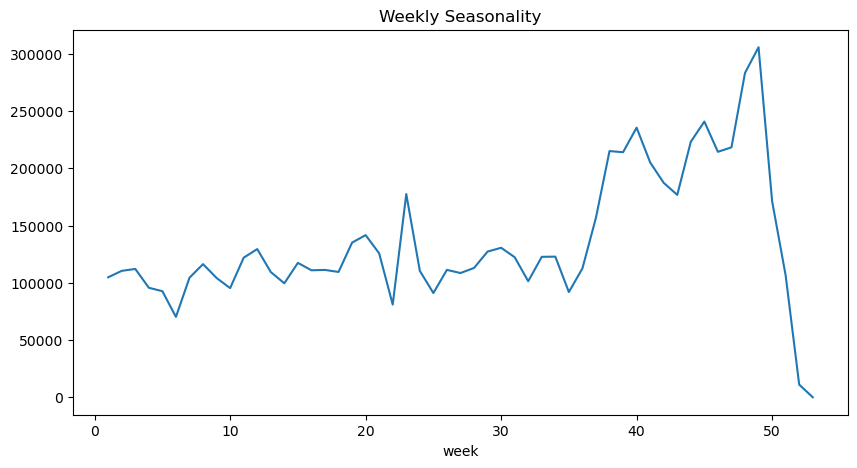

In [7]:
# Checking for week-wise seasonality
week_ = pd.Index(df.index.isocalendar().week, dtype = 'Int64')
week_ = pd.Series(week_, index = df.index)
print(week_.head(10))

df.groupby(week_)['sales'].mean().plot(figsize = (10, 5))
plt.title("Weekly Seasonality")
plt.show()

# The sales towards the end of the year are higher

week
2009-12-06    12
2009-12-13    12
2009-12-20    12
2009-12-27    12
2010-01-03     1
2010-01-10     1
2010-01-17     1
2010-01-24     1
2010-01-31     1
2010-02-07     2
Name: week, dtype: Int64


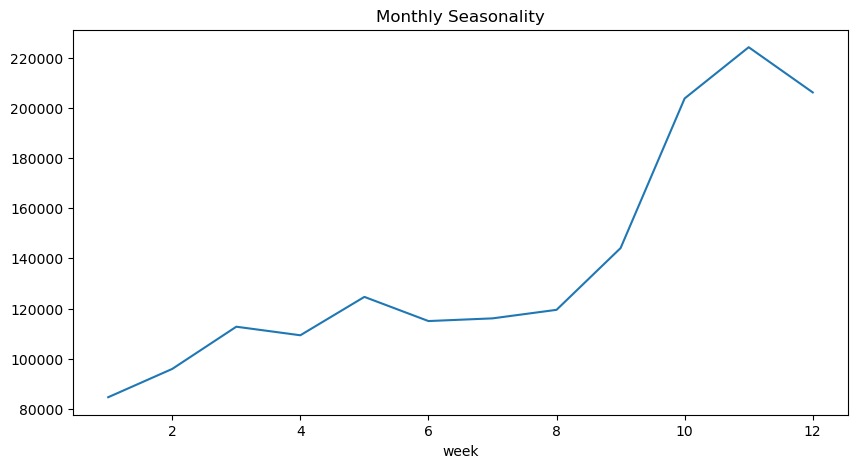

In [8]:
# Checking for month-wise seasonality
month_ = pd.Index(df.index.month, dtype = 'Int64')
month_ = pd.Series(month_, index = df.index)
print(month_.head(10))

df.groupby(month_)['sales'].mean().plot(figsize = (10, 5))
plt.title("Monthly Seasonality")
plt.show()

# The sales towards the end of the year are higher

# Feature engineering

Now, let's begin to tabularize the data.

In [9]:
# Sort the data based on the index
df.sort_index(inplace = True)

# Extract date features
df['Month'] = df.index.month
df['Week']  = df.index.isocalendar().week
df['Day']   = df.index.day

# Show new variables
df.head()

,sales,Month,Week,Day
week,,,,
2009-12-06,213000.35,12,49,6
2009-12-13,195810.04,12,50,13
2009-12-20,182396.74,12,51,20
2009-12-27,22007.77,12,52,27
2010-01-03,0.00,1,53,3


In [10]:
# Creating lag features
tmp = df['sales'].shift(freq = '1W')
tmp.columns = ["sales_lag_1"]
tmp = tmp.rename("sales_lag_1")
df = df.merge(tmp, left_index = True, right_index = True, how = "left")
df.head()

,sales,Month,Week,Day,sales_lag_1
week,,,,,
2009-12-06,213000.35,12,49,6,NaN
2009-12-13,195810.04,12,50,13,213000.35
2009-12-20,182396.74,12,51,20,195810.04
2009-12-27,22007.77,12,52,27,182396.74
2010-01-03,0.00,1,53,3,22007.77


In [11]:
# Creating lag features
tmp = df['sales'].shift(freq = '2W')
tmp.columns = ["sales_lag_2"]
tmp = tmp.rename("sales_lag_2")
df = df.merge(tmp, left_index = True, right_index = True, how = "left")
df.head()

,sales,Month,Week,Day,sales_lag_1,sales_lag_2
week,,,,,,
2009-12-06,213000.35,12,49,6,NaN,NaN
2009-12-13,195810.04,12,50,13,213000.35,NaN
2009-12-20,182396.74,12,51,20,195810.04,213000.35
2009-12-27,22007.77,12,52,27,182396.74,195810.04
2010-01-03,0.00,1,53,3,22007.77,182396.74


In [12]:
df.isnull().sum()

sales          0
Month          0
Week           0
Day            0
sales_lag_1    1
sales_lag_2    2
dtype: int64

In [13]:
df.head()

,sales,Month,Week,Day,sales_lag_1,sales_lag_2
week,,,,,,
2009-12-06,213000.35,12,49,6,NaN,NaN
2009-12-13,195810.04,12,50,13,213000.35,NaN
2009-12-20,182396.74,12,51,20,195810.04,213000.35
2009-12-27,22007.77,12,52,27,182396.74,195810.04
2010-01-03,0.00,1,53,3,22007.77,182396.74


In [14]:
# Use the rolling-mean of the previous 3 weeks as input variables
tmp = (
    df['sales']
    .rolling(window = 3)
    .mean()
    .shift(freq = '1W')
)

tmp.columns = ['sales_window']
tmp = tmp.rename('sales_window')
tmp.head()

df = df.merge(tmp, left_index = True, right_index = True, how = 'left')
df.head()

,sales,Month,Week,Day,sales_lag_1,sales_lag_2,sales_window
week,,,,,,,
2009-12-06,213000.35,12,49,6,NaN,NaN,NaN
2009-12-13,195810.04,12,50,13,213000.35,NaN,NaN
2009-12-20,182396.74,12,51,20,195810.04,213000.35,NaN
2009-12-27,22007.77,12,52,27,182396.74,195810.04,197069.043333
2010-01-03,0.00,1,53,3,22007.77,182396.74,133404.850000


In [15]:
cyclical = CyclicalFeatures(
    variables = ['Month', 'Week', 'Day'],
    drop_original = False
)

df = cyclical.fit_transform(df)

cyclical_vars = [var for var in df.columns if 'sin' in var or 'cos' in var]
df[cyclical_vars].head()

,Month_sin,Month_cos,Week_sin,Week_cos,Day_sin,Day_cos
week,,,,,,
2009-12-06,-2.449294e-16,1.000000,-0.456629,0.889657,0.937752,0.347305
2009-12-13,-2.449294e-16,1.000000,-0.348202,0.93742,0.485302,-0.874347
2009-12-20,-2.449294e-16,1.000000,-0.234886,0.972023,-0.790776,-0.612106
2009-12-27,-2.449294e-16,1.000000,-0.118273,0.992981,-0.724793,0.688967
2010-01-03,5.000000e-01,0.866025,-0.0,1.0,0.571268,0.820763


In [16]:
# Determine the fraction of missing data
df.isnull().sum() / len(df)

sales           0.000000
Month           0.000000
Week            0.000000
Day             0.000000
sales_lag_1     0.009434
sales_lag_2     0.018868
sales_window    0.028302
Month_sin       0.000000
Month_cos       0.000000
Week_sin        0.000000
Week_cos        0.000000
Day_sin         0.000000
Day_cos         0.000000
dtype: float64

In [17]:
print(f"Data Size Before: {df.shape}")
df.dropna(inplace = True)
print(f"Data Size After: {df.shape}")

Data Size Before: (106, 13)
Data Size After: (103, 13)


## Split data

Separate the data into training and testing sets, leaving the data after the last week of September to evaluate the forecasts, that is, in the testing set.

In [18]:
print(f"Min Time-Index: {df.index.min()}\nMax Time-Index: {df.index.max()}")

X_train = df[df.index <= '2011-10-02']
X_test  = df[df.index > '2011-10-02']
print(X_train.shape, X_test.shape)

y_train = X_train['sales'].copy()
y_test  = X_test['sales'].copy()

X_train = X_train.drop('sales', axis = 1)
X_test = X_test.drop('sales', axis = 1)
print(X_train.shape, X_test.shape)


Min Time-Index: 2009-12-27 00:00:00
Max Time-Index: 2011-12-11 00:00:00
(93, 13) (10, 13)
(93, 12) (10, 12)


## Naive forecast

Predict sales in the next week (t) as the value of sales in the previous week (t-1).

In [19]:
# Performance of Naive Forecast
print(f"Train RMSE: ", mse(y_train, X_train['sales_lag_1'], squared = False))
print(f"Test RMSE: ", mse(y_test, X_test['sales_lag_1'], squared = False))

Train RMSE:  48986.127532628234
Test RMSE:  63841.25959449667


## Machine Learning

In [20]:
# Training a Random Forest Model
rf_model = RandomForestRegressor(
    n_estimators = 50, max_depth = 5, random_state = 0
)

rf_model.fit(X_train, y_train)

# Performance of the model
print(f"Train RMSE: ", mse(y_train, rf_model.predict(X_train), squared = False))
print(f"Test RMSE: ", mse(y_test, rf_model.predict(X_test), squared = False))

Train RMSE:  20603.697135828545
Test RMSE:  43938.04173895867


In [21]:
# Training a Linear Regression Model
linear_model = Lasso(
    alpha = 0.2, random_state = 0, max_iter = int(5e3)
)

linear_model.fit(X_train, y_train)

# Performance of the model
print(f"Train RMSE: ", mse(y_train, linear_model.predict(X_train), squared = False))
print(f"Test RMSE: ", mse(y_test, linear_model.predict(X_test), squared = False))

Train RMSE:  38259.764035172164
Test RMSE:  63561.71777981238
